In [1]:
# Required modules
import pyift.pyift as ift
import numpy as np
import matplotlib.pyplot as plt

import os # remove after RISF is working

In [2]:
# Helper funcionts
def show(img, dpi=125):
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    frame.figure.set_dpi(125)
    frame.axes.imshow(img)
    plt.show()

def imageOverlay(original, label):
    A = ift.Circular(1.0)
    tmp = ift.CopyImage(original)
    cmap = ift.CreateColorTable(ift.MaximumValue(label) + 1)
    ift.DrawLabels(tmp, label, cmap, A, True, 0.2)
    ift.WriteImageByExt(tmp,"overlay.png")
    show(tmp.ToPlot())

In [3]:
def RISF(img, n_superpixels, n_iters=10, A=None, small_threshold=0.05, 
         seed_sampling=ift.IFT_ISF_GEODESIC_SAMPLING,
         pathcost=ift.IFT_ISF_ADD_MEAN_PATHCOST,
         seeds_recomp=ift.IFT_ISF_CENTROID_SEEDRECOMP):
    
    opt = ift.InitISFOptions(n_superpixels, n_iters, 0, small_threshold, 
                             seed_sampling, pathcost, seeds_recomp)
    
    refImg = ift.CopyImage(img)
    n = refImg.xsize * refImg.ysize * refImg.zsize
    refNp = np.linspace(0, n,num=n, dtype=np.int32).reshape((refImg.ysize, refImg.xsize))
    refImg.FromNumPy(refNp)

    if A is None:
        Adj = ift.Circular(1.0)
    else:
        Adj = A
    
    igraph = ift.InitSuperpixelIGraph(refImg)
    ift.SetSuperpixelIGraphImplicitAdjacency(igraph, Adj)
    feats = ift.ComputeSuperpixelFeaturesByColorSpaceMean(refImg, img, ift.LABNorm_CSPACE)
    ift.SetSuperpixelIGraphFeatures(igraph, feats, ift.WeightedL2NormPtr(), 0.2, 12.0)
    suppixel = ift.SuperpixelSegmentationByRISF(igraph, opt, img)

    B = ift.Circular(1.5)
    return ift.RelabelRegions(suppixel, B)

In [4]:
# Input parameters
img_path = 'flower.png'
seeds_path = 'flower.txt'

# Loading
img = ift.ReadImageByExt(img_path)
seeds = ift.ReadSeeds(img, seeds_path)

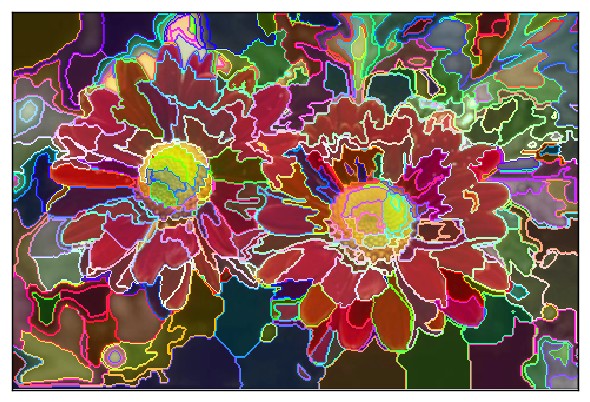

In [5]:
# Input Parameters 
n_suppixels = 400

# RISF
sup = RISF(img, n_suppixels)
imageOverlay(img, sup)

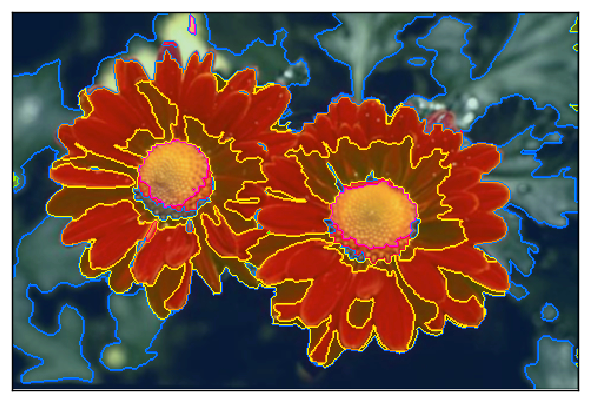

<module 'pyift.pyift' from '/home/afalcao/ift/PyIFT/pyift/pyift.py'>

In [7]:
# Input Parameters
A = ift.Circular(1.5)
use_coord = False
kmax = 30

# Extracting features
feat = ift.ExtractImageFeatures(img, sup, A, use_coord)
Z_sup = ift.MImageToDataSet(feat, sup)


knn_graph = ift.CreateKnnGraph(Z_sup, kmax)
ift.UnsupTrain(knn_graph, ift.NormalizedCutPtr())
cluster = ift.DataSetToLabelImage(Z_sup, sup, False, ift.IFT_GROUP)
imageOverlay(img, cluster)
ift

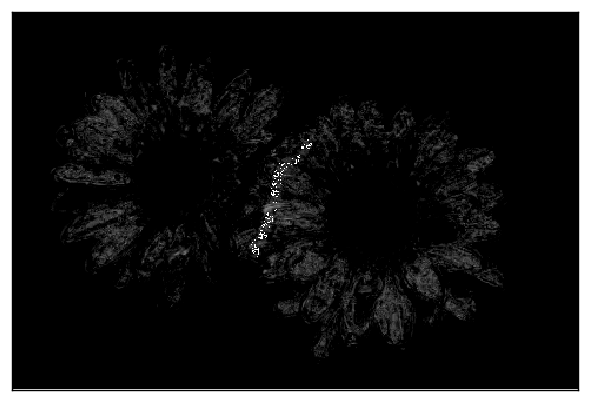

In [12]:
# Input Parameters
threshold = 0.8

# Seed Selection
obj_seeds = ift.SelectSeedsForEnhancement(seeds, cluster, 1, threshold)
ift.WriteSeeds(obj_seeds,img,"seeds.txt")
# Pixel DataSet
A = ift.Circular(1.5)
feat = ift.ExtractImageFeatures(img, None, A, False)
Z_pix = ift.MImageToDataSet(feat, None)
ift.LabelDataSetFromSeeds(Z_pix, seeds, None)

Z_pix_train = ift.ExtractSamples(Z_pix, ift.IFT_SUPERVISED)
ift.SetStatus(Z_pix_train, ift.IFT_TRAIN)
ift.AddStatus(Z_pix_train, ift.IFT_SUPERVISED)

cpl_graph = ift.CreateCplGraph(Z_pix_train)
ift.SupTrain(cpl_graph)

ift.SetStatus(Z_pix, ift.IFT_TEST)
ift.ClassifyWithCertaintyValues(cpl_graph, Z_pix)
objmap = ift.DataSetObjectMap(Z_pix, None, 255, 2)
show(objmap.ToPlot())
ift.WriteImageByExt(objmap,"objmap.png")

In [11]:
# Segmentation Inputs
mimg = ift.ImageToMImage(img, ift.LABNorm_CSPACE)
A = ift.Circular(1.0)

In [ ]:
# Input Parameters
alpha = 0.2  # Objmap Weight

# WaterCut
segm = ift.EnhancedWaterCut(mimg, objmap, A, seeds, alpha)
imageOverlay(img, segm)

### Dynamic Trees Arc-Weight Formula: 
$$w(p, q) = (1-\alpha)(w_{dyn}(p, q) + \gamma\|I(p) - I(q)\|^2) + \alpha\|O(p) - O(q)\|^2$$

As funções estão usando $\|.\|^2$ pois $ \|x_1 - x_2\|^2 = (x_1 - x_2)I_{d \times d}(x_1 - x_2)$, que se encaixa no contexto de aprendizado de métrica, tal que $d_M(x_1, x_2) = (x_1 - x_2)M(x_1 - x_2)$ é a distância para uma métrica $M$ aprendida, e equivalente a $\|Lx_1 - Lx_2\|$ onde $M = L^T L$, sendo $L$ a transformada para um novo espaço dos features.

Essa alteração não interfere nos resultados.

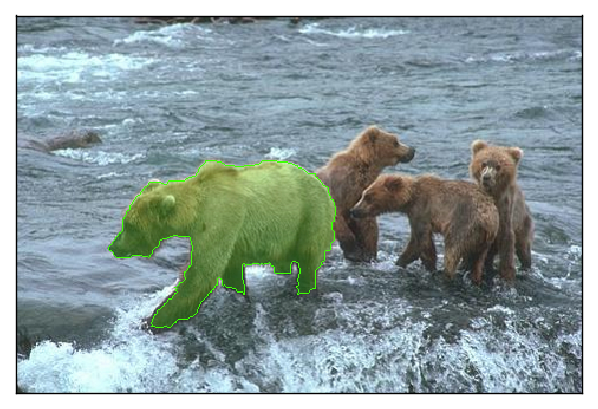

In [10]:
# Input Parameters
delta = 2    # Seed Plato Height
gamma = 0.25 # Neighbor Distance Scaling Factor
alpha = 0.2  # Objmap Weight

# DynTree
segm = ift.DynTreeRoot(mimg, A, seeds, delta, gamma, objmap, alpha)
imageOverlay(img, segm)

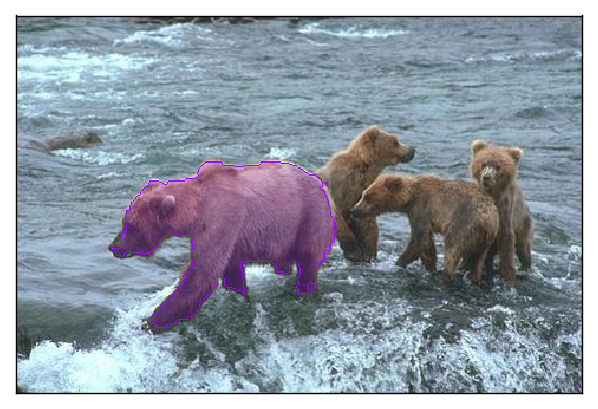

In [11]:
# Input Parameters
delta = 2    # Seed Plato Height
gamma = 0.25  # Neighbor Distance Scaling Factor
alpha = 0.2  # Objmap Weight

# DynTree
segm = ift.DynTreeClosestRoot(mimg, A, seeds, delta, gamma, objmap, alpha)
imageOverlay(img, segm)